# MLB Story: Payroll vs Performance (2015–2024)

Last Updated: August. 29th, 2025.
This notebook presents a **clean, reproducible analysis** exploring the relationship between **MLB team payrolls** and **on‑field performance** (wins, win percentage, and championships). This notebook will be continued to evolve and be improved to create better visuals and insights.

**Sections**
1. Imports & Setup  
2. Data Loading  
3. Data Cleaning & Feature Engineering  
4. Exploratory Analysis & Visualization  

## 1) Imports & Setup

In [3]:
#Install Packages
%pip install pandas numpy matplotlib seaborn plotly scikit-learn umap-learn hdbscan ipython

Note: you may need to restart the kernel to use updated packages.


In [49]:
#Import packages
#Data Wranglings
import pandas as pd
import numpy as np

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import plotly.express as px #Interactive Visuals on Notebook

#For Dimensionality reduction and clustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import umap
import hdbscan
from scipy.stats import pearsonr

#Notebook utilities/ test utilities
import re
from IPython.display import display

# Reproducibility
import random
np.random.seed(42)
random.seed(42)


## 2) Data Loading

In [50]:
# Lahman Teams table (official mirror)
#LAHMAN_TEAMS_URL = "https://sabr.app.box.com/s/rsry2en86bimvybwsorumfsxmf91002a?page=1"
#Salary data imported from = "https://www.kaggle.com/api/v1/datasets/download/christophertreasure/mlb-player-salaries-2011-2024"

teams = pd.read_csv("Teams.csv") #Team Stat
apps = pd.read_csv("Appearances.csv") #Player Appearance
salaries = pd.read_csv("mlb_salary_data.csv", encoding="latin1")  #Player salaries, encoding latin1

# Filter 2015–2024
teams_modern = teams[(teams["yearID"] >= 2015) & (teams["yearID"] <= 2024)].copy()
apps = apps[(apps["yearID"] >= 2015) & (apps["yearID"] <= 2024)].copy()
salaries["Year"] = salaries["Year"].astype(int)
salaries = salaries[(salaries["Year"]>=2015) & (salaries["Year"]<=2024)].copy()

In [51]:
# Data check
print(teams_modern.head())
print(teams_modern.columns)

print(salaries.head())
print(salaries.columns)

print(apps.head())
print(apps.columns)

    yearID lgID teamID franchID divID  Rank    G  Ghome   W   L  ...   DP  \
55    2015   AL    LAA      ANA     W     3  162   81.0  85  77  ...  108   
56    2016   AL    LAA      ANA     W     4  162   81.0  74  88  ...  148   
57    2017   AL    LAA      ANA     W     2  162   81.0  80  82  ...  135   
58    2018   AL    LAA      ANA     W     4  162   81.0  80  82  ...  173   
59    2019   AL    LAA      ANA     W     4  162   81.0  72  90  ...  118   

       FP                           name                      park  \
55  0.984  Los Angeles Angels of Anaheim  Angel Stadium of Anaheim   
56  0.983  Los Angeles Angels of Anaheim  Angel Stadium of Anaheim   
57  0.986  Los Angeles Angels of Anaheim  Angel Stadium of Anaheim   
58  0.987  Los Angeles Angels of Anaheim  Angel Stadium of Anaheim   
59  0.984  Los Angeles Angels of Anaheim  Angel Stadium of Anaheim   

    attendance  BPF  PPF  teamIDBR  teamIDlahman45  teamIDretro  
55   3012765.0   94   95       LAA             ANA

## 3) Data Cleaning & Feature Engineering

### Lahman team table — field index

| Field             | Description |
|-------------------|-------------|
| **`yearID`**      | Year |
| `lgID`            | League |
| **`teamID`**      | Team |
| **`franchID`**    | Franchise (links to TeamsFranchise table) |
| `divID`           | Team's division |
| `Rank`            | Position in final standings |
| **`G`**           | Games played |
| `GHome`           | Games played at home |
| **`W`**           | Wins |
| **`L`**           | Losses |
| **`DivWin`**      | Division Winner (`Y`/`N`) |
| **`WCWin`**       | Wild Card Winner (`Y`/`N`) |
| **`LgWin`**       | League Champion (`Y`/`N`) |
| **`WSWin`**       | World Series Winner (`Y`/`N`) |
| **`R`**           | Runs scored |
| `AB`              | At bats |
| **`H`**           | Hits by batters |
| **`2B`**          | Doubles |
| **`3B`**          | Triples |
| **`HR`**          | Home runs by batters |
| **`BB`**          | Walks by batters |
| **`SO`**          | Strikeouts by batters |
| **`SB`**          | Stolen bases |
| `CS`              | Caught stealing |
| **`HBP`**         | Batters hit by pitch |
| **`SF`**          | Sacrifice flies |
| **`RA`**          | Opponents' runs scored |
| **`ER`**          | Earned runs allowed |
| **`ERA`**         | Earned run average |
| `CG`              | Complete games |
| `SHO`             | Shutouts (team level) |
| **`SV`**          | Saves |
| `IPOuts`          | Outs pitched (`innings * 3`) |
| `HA`              | Hits allowed |
| `HRA`             | Home runs allowed |
| `BBA`             | Walks allowed |
| `SOA`             | Strikeouts by pitchers |
| `E`               | Errors |
| `DP`              | Double plays (team level) |
| `FP`              | Fielding percentage |
| **`name`**        | Team's full name |
| `park`            | Name of team's home ballpark |
| `attendance`      | Home attendance total |
| `BPF`             | Three-year park factor (batters) |
| `PPF`             | Three-year park factor (pitchers) |
| `teamIDBR`        | Team ID used by Baseball-Reference |
| `teamIDlahman45`  | Team ID used in Lahman DB v4.5 |
| `teamIDretro`     | Team ID used by Retrosheet |

In [128]:
# Rename some ofthe Clean name and add Win Percentage
# teams like ARI, ATL, BOS etc. already match and don’t need remapping
team_map = {
    "CHN": "CHC",
    "CHA": "CHW",
    "KCA": "KC",
    "SDN": "SD",
    "SFN": "SF",
    "SLN": "STL",
    "TBA": "TB",
    "NYA": "NYY",
    "NYN": "NYM",
    "LAN": "LAD",
    "WAS": "WSH"
}

teams_modern["teamID"] = teams_modern["teamID"].replace(team_map)
apps["teamID"] = apps["teamID"].replace(team_map)

keep_cols = [
    "yearID","teamID","franchID","name",
    "W","L","G","R","RA","HR","SB","BB","SO",
    "H","2B","3B","SF","HBP","ERA","ER","SV",
    "DivWin","WCWin","LgWin","WSWin"
]
team_stats = teams_modern[keep_cols].copy()
team_stats = team_stats.rename(columns={"yearID":"Year","teamID":"Team","name":"TeamName"})
team_stats["WinPct"] = team_stats["W"] / (team_stats["W"] + team_stats["L"])

In [ ]:
#Clean up the Salary dataframe
sal = salaries.copy()
sal = salaries.rename(columns={
    "Name": "Player" 
})

# Keep just the essentials; drop rows missing any
needed = ["Year","Team","Player","Salary"]
missing = [c for c in needed if c not in sal.columns]
if missing:
    raise ValueError(f"Missing needed columns: {missing}")
sal = sal[needed].dropna()

# Clean up salary string to have a INT
import re
def to_number(x):
    if pd.isna(x): return None
    if isinstance(x,(int,float)): return x
    x = str(x)
    x = re.sub(r"[^0-9.\-]", "", x) # remove $ , and any stray text
    return pd.to_numeric(x, errors="coerce")

sal["Salary"] = sal["Salary"].apply(to_number)
sal = sal.dropna(subset=["Salary"])

In [ ]:
# GINI Coefficient: measures the inequality within a group
def gini(x):
    """Gini coefficient (0=equal, 1=concentrated)."""
    arr = np.array(x, dtype=float)
    if len(arr) == 0: return np.nan
    arr = np.sort(arr)
    n = len(arr)
    cum = np.cumsum(arr)
    if arr.sum() == 0: return 0.0
    return ((n + 1) / n) - 2.0 * cum.sum() / (n * arr.sum())

# Top 'K' player's payroll share within a team
def top_share(values, k):
    vals = np.sort(np.array(values, dtype=float))[::-1]
    topk = vals[:k].sum() if len(vals)>=k else vals.sum()
    total = vals.sum()
    return topk/total if total>0 else np.nan

# Segregate Top1, 3, and 5
payroll = (
    sal.groupby(["Team","Year"])
     .agg(
         TOTAL_PAYROLL=("Salary","sum"),
         N_PLAYERS=("Player","nunique"),
         GINI=("Salary", gini),
         TOP1_SHARE=("Salary", lambda x: top_share(x,1)),
         TOP3_SHARE=("Salary", lambda x: top_share(x,3)),
         TOP5_SHARE=("Salary", lambda x: top_share(x,5)),
         MEDIAN_SAL=("Salary","median"),
         MEAN_SAL=("Salary","mean")
     )
     .reset_index()
)

# Identify the top earner per Team-Year and what their payroll is that year
top1 = (
    sal.loc[sal.groupby(["Team", "Year"])["Salary"].idxmax(), ["Team", "Year", "Player", "Salary"]]
       .rename(columns={"Player": "TOP1_PLAYER", "Salary": "TOP1_SALARY"})
       .reset_index(drop=True)
)

# Attach to the payroll summary
payroll = payroll.merge(top1, on=["Team", "Year"], how="left")

In [ ]:
# Merge Payroll with Team Stat 
mlb_merged = payroll.merge(team_stats, on=["Team","Year"], how="left")

# Simplify roles and designate a role to each player
def collapse_role(row):
    roles = {
        "P": row["G_p"], #Pitcher
        "C": row["G_c"], #Catcher
        "IF": row["G_1b"] + row["G_2b"] + row["G_3b"] + row["G_ss"], #Infielder
        "OF": row["G_lf"] + row["G_cf"] + row["G_rf"], #Outfielder
        "DH": row["G_dh"] #Designated Hitter
    }
    return max(roles, key=roles.get) if sum(roles.values())>0 else "UNK"

# Apply role simplification and designation 
apps["PrimaryRole"] = apps.apply(collapse_role, axis=1)

apps_simple = apps[["yearID","teamID","playerID","PrimaryRole"]].copy()
apps_simple.rename(columns={"yearID":"Year","teamID":"Team"}, inplace=True)

In [175]:
# Quick Sanity Check
role_counts = (
    apps_simple
    .groupby(["Year","Team","PrimaryRole"])["playerID"]
    .nunique()
    .unstack(fill_value=0)
    .reset_index()
)

role_counts["TOTAL_PLAYERS"] = role_counts[["P","C","IF","OF","DH"]].sum(axis=1)

# Proportions
for r in ["P","C","IF","OF","DH"]:
    role_counts[r+"_ROSTER_SHARE"] = role_counts[r] / role_counts["TOTAL_PLAYERS"]

print(role_counts.head())

cols = ["P_ROSTER_SHARE","C_ROSTER_SHARE","IF_ROSTER_SHARE","OF_ROSTER_SHARE","DH_ROSTER_SHARE"]

# calculate row-wise sum
mlb_df["share_sum"] = mlb_df[cols].sum(axis=1)

# inspect distribution
print(mlb_df["share_sum"].describe())

# check if all are equal to 1 (within floating point tolerance)
all_close = np.allclose(mlb_df["share_sum"], 1.0)
print("All rows sum to 1:", all_close)
print(mlb_df["share_sum"].head())

PrimaryRole  Year Team  C  DH  IF  OF   P  UNK  TOTAL_PLAYERS  P_ROSTER_SHARE  \
0            2015  ARI  6   0   8   9  27    0             50        0.540000   
1            2015  ATL  3   0  13   8  36    0             60        0.600000   
2            2015  BAL  3   2  10  11  22    0             48        0.458333   
3            2015  BOS  3   2  11   9  26    0             51        0.509804   
4            2015  CHC  4   0   9  10  27    0             50        0.540000   

PrimaryRole  C_ROSTER_SHARE  IF_ROSTER_SHARE  OF_ROSTER_SHARE  DH_ROSTER_SHARE  
0                  0.120000         0.160000         0.180000         0.000000  
1                  0.050000         0.216667         0.133333         0.000000  
2                  0.062500         0.208333         0.229167         0.041667  
3                  0.058824         0.215686         0.176471         0.039216  
4                  0.080000         0.180000         0.200000         0.000000  
count    2.990000e+02
mean 

In [ ]:
# Merge Role count to current master dataframe (mlb_merge --> mlb_df)
mlb_df = mlb_merged.merge(role_counts, left_on=["Year","Team"], right_on=["Year","Team"], how="left")

# Approximate payroll split using roster shares
mlb_df["PitcherPayrollEst"] = mlb_df["TOTAL_PAYROLL"] * mlb_df["P_ROSTER_SHARE"] #Pitcher total payroll
mlb_df["HitterPayrollEst"]  = mlb_df["TOTAL_PAYROLL"] * (
    mlb_df["C_ROSTER_SHARE"] + mlb_df["IF_ROSTER_SHARE"] + mlb_df["OF_ROSTER_SHARE"] + mlb_df["DH_ROSTER_SHARE"]) #non-pitcher total payroll
mlb_df["PitcherPayrollShareEst"] = mlb_df["PitcherPayrollEst"] / mlb_df["TOTAL_PAYROLL"] #Pitcher payroll share
mlb_df["HitterPayrollShareEst"]  = mlb_df["HitterPayrollEst"] / mlb_df["TOTAL_PAYROLL"] #non-pitcher payroll share


# Aggregate across years (mean per team)
avg_shares = (
    mlb_df.groupby("Team")[["PitcherPayrollShareEst","HitterPayrollShareEst"]]
    .mean()
    .reset_index()
)

# Convert to long form for stacked barplot
avg_shares_long = avg_shares.melt(
    id_vars="Team",
    value_vars=["PitcherPayrollShareEst","HitterPayrollShareEst"],
    var_name="Role", value_name="Share"
)

In [ ]:
# Final Clean up
# Convert Y/N → 1/0 for winner flags
flag_cols = ["DivWin", "LgWin", "WSWin"]

for c in flag_cols:
    mlb_df[c] = (
        mlb_df[c]
        .astype(str).str.strip().str.upper()          # handle ' y ', 'n', etc.
        .map({"Y": 1, "N": 0})                         # map to ints
        .fillna(0)                                     
        .astype(int)
    )

#Calculate and add Run Difference
mlb_df["RunDiff"] = mlb_df["R"] - mlb_df["RA"]

## 4) Exploratory Analysis & Visualization

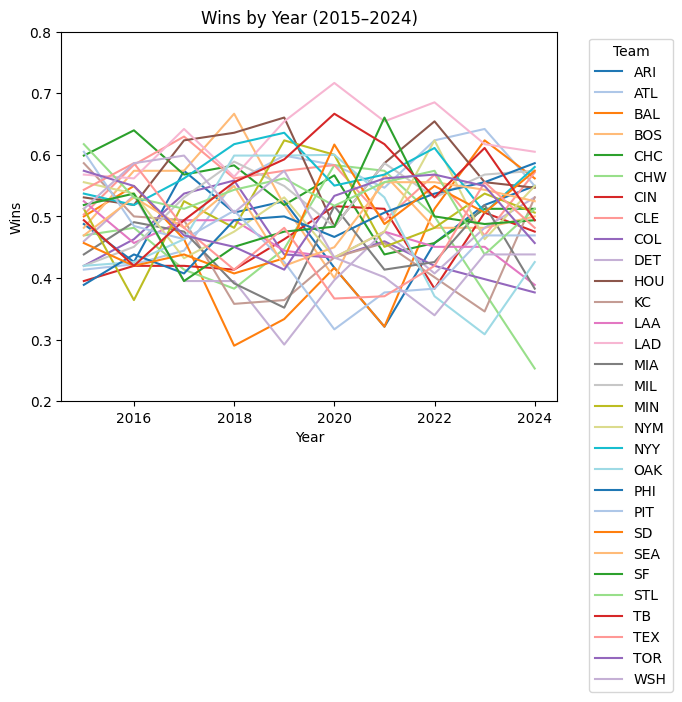

In [108]:
#Teams' Win Percentage across the year. 
sns.lineplot(
    data=mlb_df,
    x="Year", y="WinPct",
    hue="Team",
    estimator="mean",
    errorbar=None,
    palette="tab20"
)
plt.title("Wins by Year (2015–2024)")
plt.legend(title="Team", bbox_to_anchor=(1.05,1), loc='upper left')
plt.ylabel("Wins")
plt.ylim(0.2, 0.8)
plt.show()

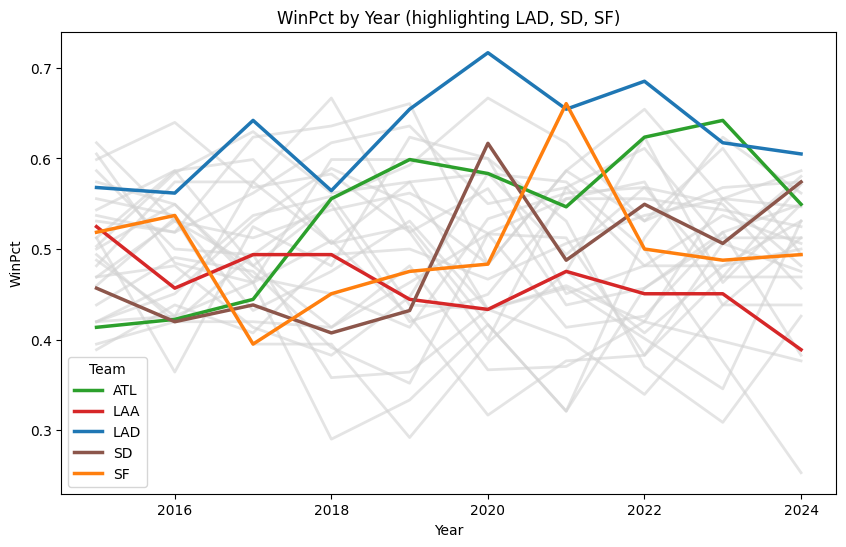

In [176]:
#California Teams' Win Percentage across the year. 

focus = {"ATL","LAA","LAD","SD","SF"}
focus_palette = {"ATL":"tab:green","LAA":"tab:red","LAD":"tab:blue","SD":"tab:brown","SF":"tab:orange"}

bg = mlb_df[~mlb_df["Team"].isin(focus)]   # non-focus
fg = mlb_df[ mlb_df["Team"].isin(focus)]   # focus

plt.figure(figsize=(10,6))

# 1) draw ALL other teams in gray, no legend
sns.lineplot(
    data=bg, x="Year", y="WinPct",
    units="Team", estimator=None,   # draw one line per team
    color="lightgray", linewidth=2, alpha=0.6,
    legend=False
)

# 2) draw focus teams in color, WITH legend
ax = sns.lineplot(
    data=fg, x="Year", y="WinPct",
    hue="Team", palette=focus_palette,
    linewidth=2.5, alpha=1.0, legend=True
)

ax.set_title("WinPct by Year (highlighting LAD, SD, SF)")
ax.set_ylabel("WinPct")
plt.show()

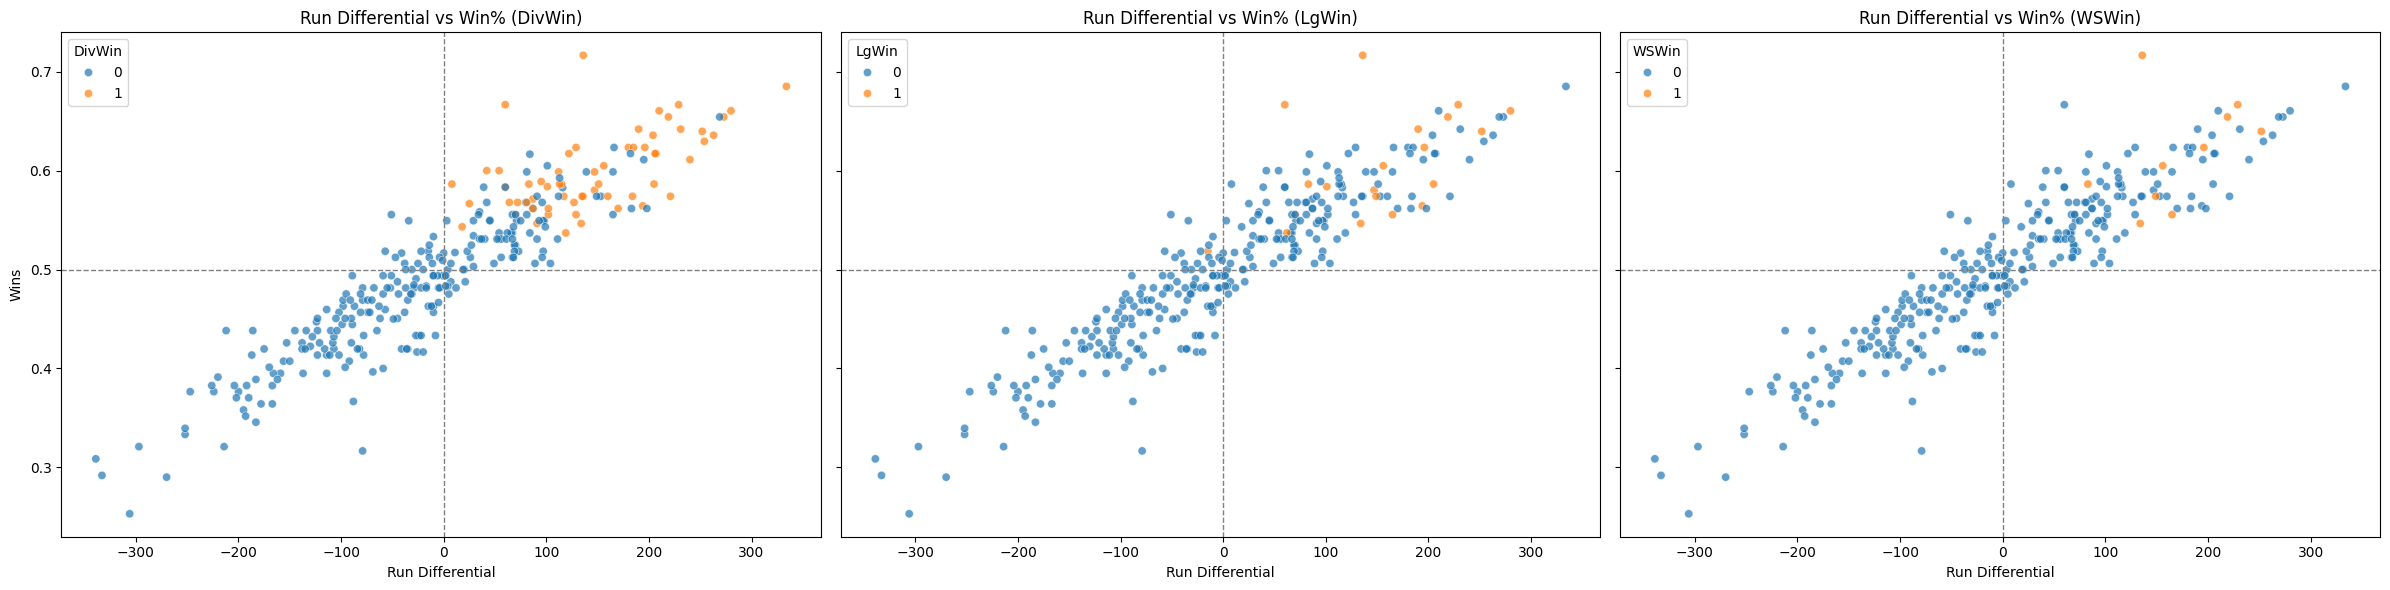

In [127]:
#Does Run Difference Track with Season performance? Run Differential vs Win%
fig, axes = plt.subplots(1, 3, figsize=(24,6), sharey=True)  # 1 row, 3 columns

# 1) DivWin
sns.scatterplot(data=mlb_df, x="RunDiff", y="WinPct", hue="DivWin", alpha=0.7, ax=axes[0])
axes[0].axhline(.5, color="gray", ls="--", lw=1)
axes[0].axvline(0, color="gray", ls="--", lw=1)
axes[0].set_title("Run Differential vs Win% (DivWin)")
axes[0].set_xlabel("Run Differential")
axes[0].set_ylabel("Wins")

# 2) LgWin
sns.scatterplot(data=mlb_df, x="RunDiff", y="WinPct", hue="LgWin", alpha=0.7, ax=axes[1])
axes[1].axhline(.5, color="gray", ls="--", lw=1)
axes[1].axvline(0, color="gray", ls="--", lw=1)
axes[1].set_title("Run Differential vs Win% (LgWin)")
axes[1].set_xlabel("Run Differential")
axes[1].set_ylabel("")

# 3) WSWin
sns.scatterplot(data=mlb_df, x="RunDiff", y="WinPct", hue="WSWin", alpha=0.7, ax=axes[2])
axes[2].axhline(.5, color="gray", ls="--", lw=1)
axes[2].axvline(0, color="gray", ls="--", lw=1)
axes[2].set_title("Run Differential vs Win% (WSWin)")
axes[2].set_xlabel("Run Differential")
axes[2].set_ylabel("")

plt.tight_layout()
plt.show()

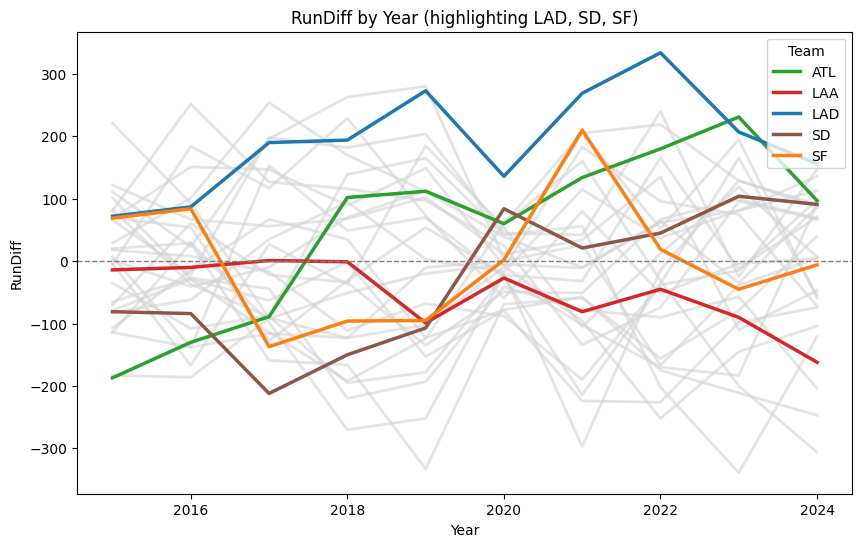

In [177]:
# California teams' RunDiff over the years

focus = {"ATL","LAA","LAD","SD","SF"}
focus_palette = {"ATL":"tab:green","LAA":"tab:red","LAD":"tab:blue","SD":"tab:brown","SF":"tab:orange"}

bg = mlb_df[~mlb_df["Team"].isin(focus)]   # non-focus
fg = mlb_df[ mlb_df["Team"].isin(focus)]   # focus

plt.figure(figsize=(10,6))

# 1) draw ALL other teams in gray, no legend
sns.lineplot(
    data=bg, x="Year", y="RunDiff",
    units="Team", estimator=None,   # draw one line per team
    color="lightgray", linewidth=2, alpha=0.6,
    legend=False
)

# 2) draw focus teams in color, WITH legend
ax = sns.lineplot(
    data=fg, x="Year", y="RunDiff",
    hue="Team", palette=focus_palette,
    linewidth=2.5, alpha=1.0, legend=True
)
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
ax.set_title("RunDiff by Year (highlighting LAD, SD, SF)")
ax.set_ylabel("RunDiff")
plt.show()

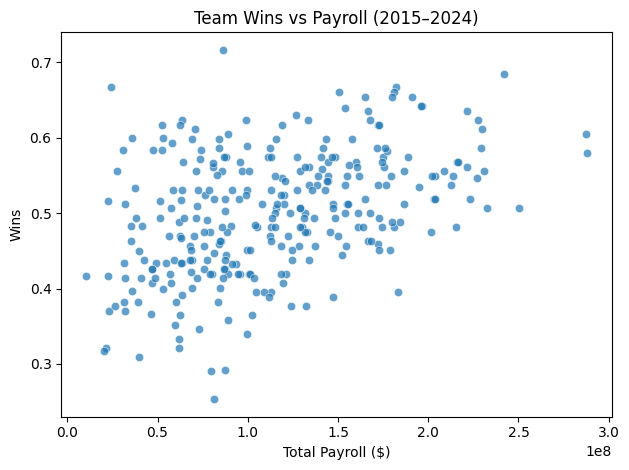

In [65]:
#Payroll v wins
plt.figure()
sns.scatterplot(
    data=mlb_df, 
    x="TOTAL_PAYROLL", 
    y="WinPct", 
    #hue="Team", 
    #palette="turbo", 
    alpha=0.7
)
plt.title("Team Wins vs Payroll (2015–2024)")
plt.xlabel("Total Payroll ($)")
plt.ylabel("Wins")
#plt.legend(title="Year", bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

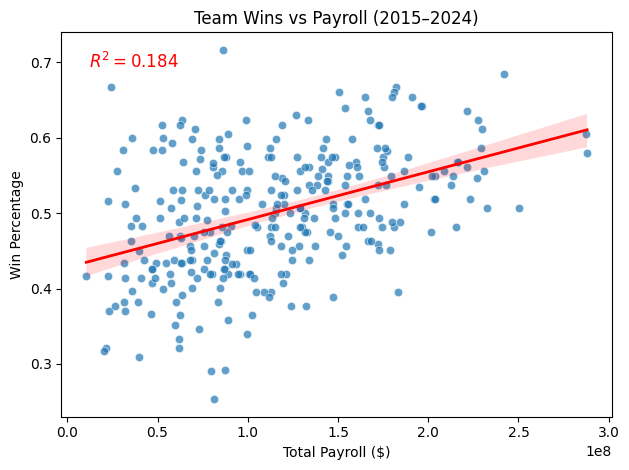

In [181]:
# Team Wins vs Payroll scatter point with Pearson correlation coefficient

# compute correlation
r, pval = pearsonr(mlb_df["TOTAL_PAYROLL"], mlb_df["WinPct"])
r2 = r**2

# Original plot
plt.figure()
sns.scatterplot(
    data=mlb_df, 
    x="TOTAL_PAYROLL", 
    y="WinPct", 
    alpha=0.7
)

# add regression line (linear fit)
sns.regplot(
    data=mlb_df,
    x="TOTAL_PAYROLL",
    y="WinPct",
    scatter=False,          # don't re-plot the points
    ci=95,
    line_kws={"color":"red", "lw":2}   # style of the line
)

# annotate R^2 on plot
plt.text(
    0.05, 0.95, f"$R^2 = {r2:.3f}$", 
    transform=plt.gca().transAxes,   # relative to axes (0–1 coords)
    ha="left", va="top", fontsize=12, color="red"
)

plt.title("Team Wins vs Payroll (2015–2024)")
plt.xlabel("Total Payroll ($)")
plt.ylabel("Win Percentage")
plt.tight_layout()
plt.show()

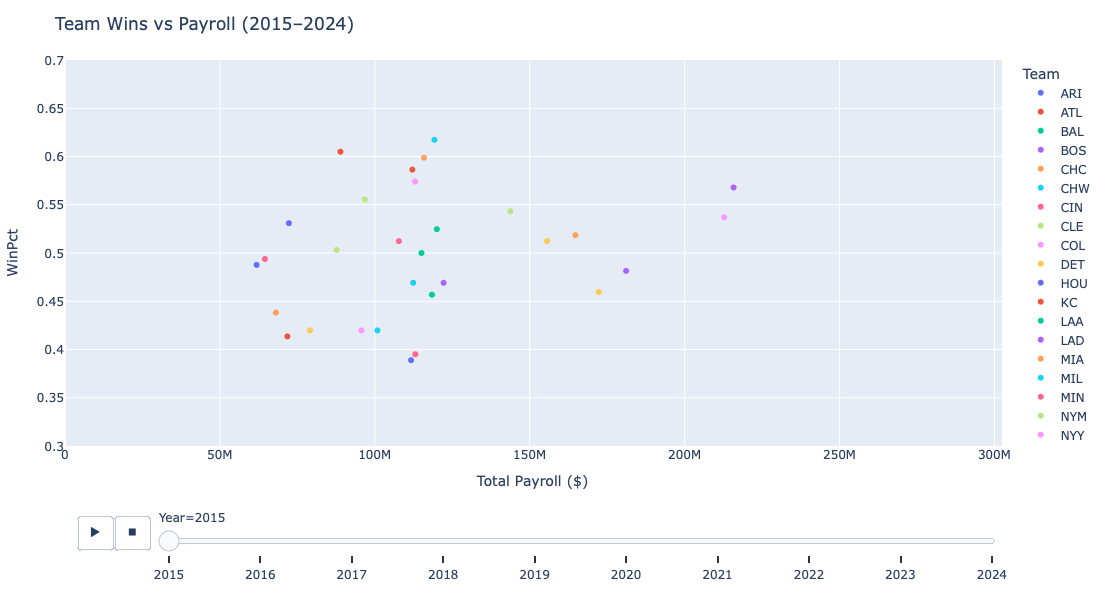

In [185]:
#Interactive scatterplot showing per year
year_col = next((c for c in ["Year", "year"] if c in mlb_df.columns), None)

xmax = mlb_df["TOTAL_PAYROLL"].max() * 1.05 

base_kwargs = dict(
    x="TOTAL_PAYROLL",
    y="WinPct",
    color="Team",
    hover_name="Team",
    labels={"TOTAL_PAYROLL": "Total Payroll ($)", "W": "Wins"},
    title="Team Wins vs Payroll (2015–2024)",
    range_x=[0, xmax],
    range_y=[0.3, 0.7],
    color_continuous_scale="Viridis"
)

if year_col:
    fig = px.scatter(mlb_df, animation_frame=year_col, **base_kwargs)
else:
    fig = px.scatter(mlb_df, **base_kwargs)

# Nice touches
fig.update_layout(
    legend_title_text="Team",
    hovermode="closest",
    margin=dict(l=40, r=40, t=60, b=40),
    width=900,
    height=600
)
# Format payroll with thousands separators on hover
fig.update_traces(
    hovertemplate="<b>%{hovertext}</b><br>" +
                  "Payroll: %{x:,}<br>" +
                  "Wins: %{y}<extra></extra>"
)

fig.show()

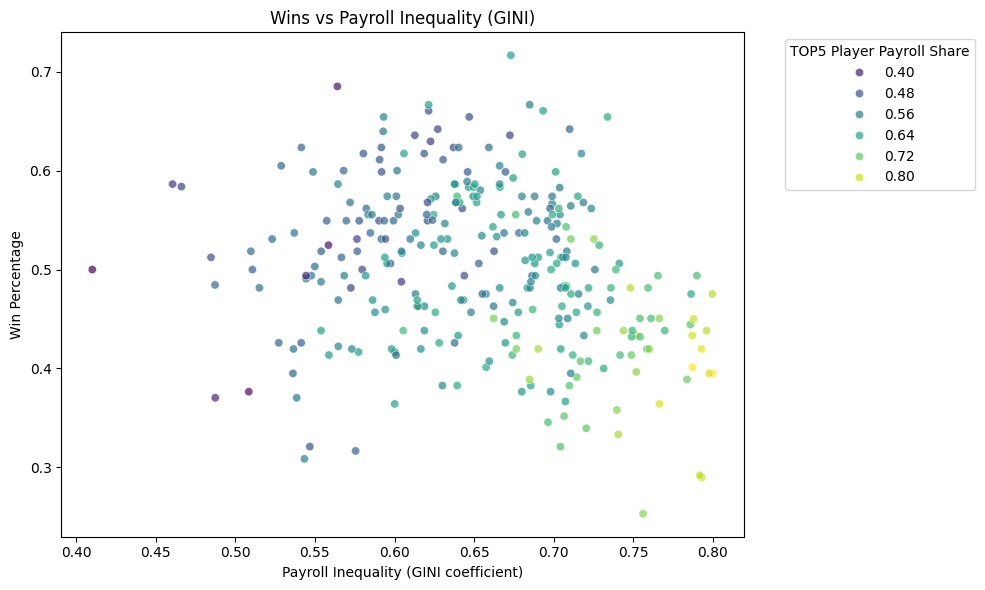

In [186]:
#Payroll inequality (GINI) v Win Percentage
# color by TeamModern
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=mlb_df,
    x="GINI",
    y="WinPct",
    hue="TOP5_SHARE",
    alpha=0.7,
    palette="viridis",
    legend="auto" 
)
plt.title("Wins vs Payroll Inequality (GINI)")
plt.xlabel("Payroll Inequality (GINI coefficient)")
plt.ylabel("Win Percentage")
plt.legend(title="TOP5 Player Payroll Share", bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
plt.show()

<Axes: xlabel='GINI', ylabel='WinPct'>

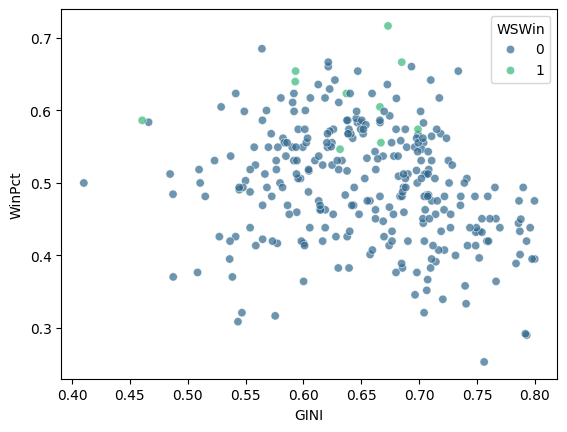

In [78]:
sns.scatterplot(
    data=mlb_df,
    x="GINI",
    y="WinPct",
    hue="Year",
    palette="viridis",
    alpha=0.7
)

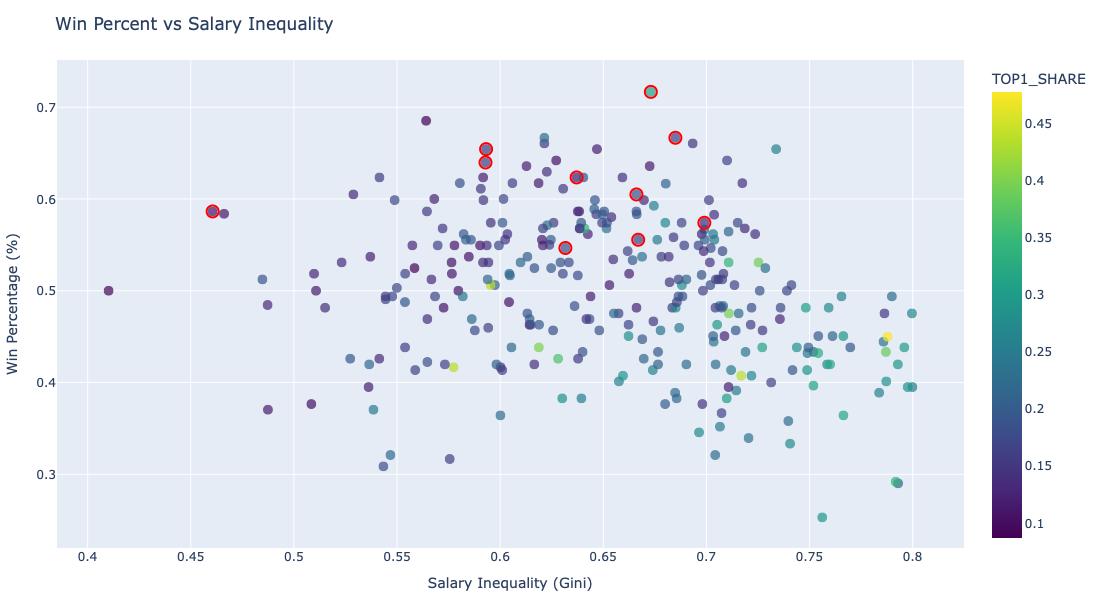

In [152]:
#Interactive scatter plot of Gini vs Win Pct

fig = px.scatter(
    mlb_df, 
    x="GINI", 
    y="WinPct", 
    color="TOP1_SHARE",             # optional: color by Year
    hover_name="Team",        # label shown when hovering
    hover_data={
        "Year": True,
        "TOTAL_PAYROLL": ":,", # format with commas
        "Team": True,
        "N_PLAYERS": True,
        "TOP1_SHARE": ":.3f",
        "TOP3_SHARE": ":.3f",
        "TOP5_SHARE": ":.3f",
        "TOP1_PLAYER": True,
        "TOP1_SALARY": ":,", # format with commas
    },
    color_continuous_scale="Viridis",
    labels={
        "WinPct": "Win Percentage (%)",
        "GINI": "Salary Inequality (Gini)"
    },
    title="Win Percent vs Salary Inequality"
)

fig.update_traces(marker=dict(size=10, opacity=0.7, line=dict(width=0)))
fig.update_layout(
    hovermode="closest",
    margin=dict(l=40, r=40, t=60, b=40),
    width=900,
    height=600
)

fig.update_traces(marker=dict(size=10, opacity=0.7, line=dict(width=0)))
fig.update_layout(
    hovermode="closest",
    margin=dict(l=40, r=40, t=60, b=40),
    width=900,
    height=600
)

# Add black outlines only for Highlight == 1
winners = mlb_df[mlb_df["WSWin"] == 1]
fig.add_scatter(
    x=winners["GINI"],
    y=winners["WinPct"],
    mode="markers",
    marker=dict(
        size=12,
        color="rgba(0,0,0,0)",   # hollow fill
        line=dict(color="red", width=2)
    ),
    name="WS Winners",
    showlegend=False
)

fig.show()

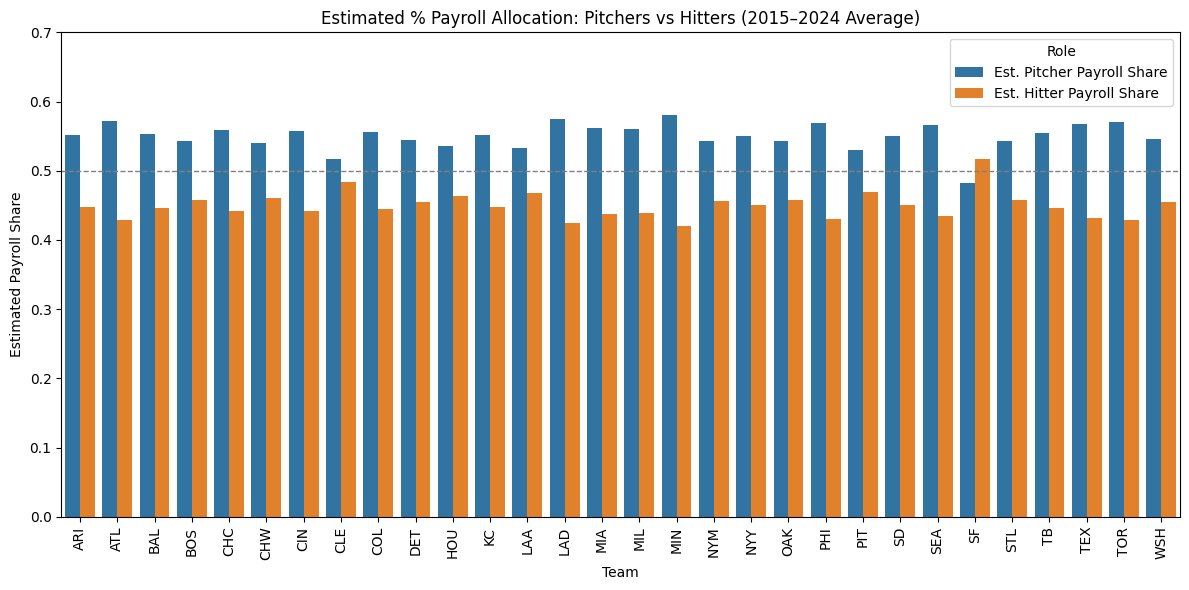

In [53]:
# Average Payroll Pitchers vs Hitters
plt.figure(figsize=(12,6))
ax = sns.barplot(
    data=avg_shares_long,
    x="Team",
    y="Share",
    hue="Role",
    palette=["#1f77b4","#ff7f0e"]
)

plt.axhline(0.5, color="gray", linestyle="--", linewidth=1)

plt.title("Estimated % Payroll Allocation: Pitchers vs Hitters (2015–2024 Average)")
plt.ylabel("Estimated Payroll Share")
plt.xlabel("Team")
plt.xticks(rotation=90)

# get current legend entries
handles, labels = ax.get_legend_handles_labels()

# map old -> new labels (adjust keys to match your actual Role values)
label_map = {
    "PitcherPayrollShareEst": "Est. Pitcher Payroll Share",
    "HitterPayrollShareEst":  "Est. Hitter Payroll Share",
    "Pitcher": "Est. Pitcher Payroll Share",
    "Hitter":  "Est. Hitter Payroll Share"
}
new_labels = [label_map.get(l, l) for l in labels]
plt.legend(handles, new_labels, title="Role", loc="best")

plt.ylim(0, 0.7)
plt.tight_layout()
plt.show()

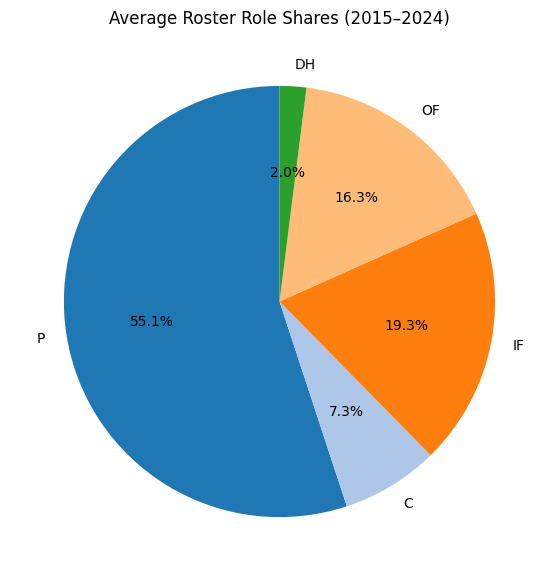

In [83]:
# Average Payroll share of each role

role_shares = ["P_ROSTER_SHARE","C_ROSTER_SHARE","IF_ROSTER_SHARE","OF_ROSTER_SHARE","DH_ROSTER_SHARE"]

# compute average across all teams/years
avg_roles = mlb_df[role_shares].mean().round(3)

# pie chart
plt.figure(figsize=(7,7))
plt.pie(
    avg_roles,
    labels=avg_roles.index.str.replace("_ROSTER_SHARE",""),  # cleaner labels
    autopct="%1.1f%%",   # show percentages
    startangle=90,       # start from top
    colors=plt.cm.tab20.colors[:len(avg_roles)]  # pick a consistent palette
)
plt.title("Average Roster Role Shares (2015–2024)")
plt.show()